In [1]:

# environment setup
import os
# one API particularly on Intel architectures Deep Neural Network Library (oneDNN)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# NVIDIA's GPU-accelerated library for Deep Neural Network Library (cuDNN)
os.environ['TF_ENABLE_CUDNN_OPTS'] = '1'

# The output messages generated during the execution of DeepReg functions.(0..4)
os.environ['DEEPREG_LOG_LEVEL'] = '2' # WARNING: Indicates potential issues that are not necessarily errors.

# TensorFlow to control the logging level (0..4)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # WARNING logs and above are shown (removes INFO and DEBUG logs).



import tensorflow as tf
from tensorflow.keras.layers import Input,Dense, GRU, LSTM, SimpleRNN, Flatten, Dropout,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time



# Clears the default graph stack and resets the global default graph
tf.compat.v1.reset_default_graph()

# # for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done


# Return a list of physical devices visible to the host runtime.
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth for each GPU to true
        for gpu in gpus:           
            
            # Set if memory growth should be enabled for a PhysicalDevice
            tf.config.experimental.set_memory_growth(gpu, True)
            
            # print(str(gpu[0][-5:])) # cut out from the message 'gpu' only the GPU unit name (example GPU:0)
            # Resets the tracked memory stats for the chosen device.
            tf.config.experimental.reset_memory_stats(str(gpu[0][-5:]))
            # according to tensorflow documentation, it does not currently work for CPU
            
        # Return a list of logical devices created by runtime.   
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        # lists GPU devices and specifies whether virtual memory expansion is enabled
        for gpu in gpus:
            print(f"Device: {gpu}, Memory Growth: {tf.config.experimental.get_memory_growth(gpu)}")

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

      

1 Physical GPUs, 1 Logical GPUs
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), Memory Growth: True


In [2]:

# incarca seul de date
path = os.path.join("dataset/train_dataset")
train_dataset = tf.data.Dataset.load(path)

path = os.path.join("dataset/val_dataset")
val_dataset = tf.data.Dataset.load(path)

names_class = pd.read_csv('dataset/list_label_name.csv')
names_class = names_class[names_class.columns[1]].values.tolist()

print('names_class : ', names_class)



names_class :  ['Drink', 'Picking', 'Push', 'Run', 'Throwing objects', 'boxing', 'lifting weights', 'receiving the phone', 'stand', 'walking on stairs', 'walking with flashlight', 'waving']


In [3]:
# Configuring the dataset for better performance

# - prefetch(): Este un API care realizeaza preancarcarea datelor (s+1) in timp ce modelul proceseaza datele anterioare (s)
#               Parametrizarea poate fi facuta manual sau automata tf.data.AUTOTUNE (prefetch(buffer_size=AUTOTUNE))
#               In cazul setari manual a cestui API, buffer_size trebuie sa fie mai mare sau egal cu numarul de loturi consumate intr-o epoca

# - cache(): Păstrează datele în memorie după ce au fost încărcate de pe disc în o anumita perioade de timp.
#            Acest lucru va salva unele operațiuni (cum ar fi deschiderea fișierelor și citirea datelor) de la executarea în fiecare epocă.

# .shuffle(100) - coeficient de amestecare


AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE).shuffle(1234)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
# desface val_dataset pentru a vedea dimesunile tensorilor 
def test_dataset(dataset):
   
    feauter = [0]
    labels = [0]

    # itereaza tensorul conpus din feauter si labels (x,y)
    for x, y in dataset:
        
        # numara cate pachete sunt (prima cifra)
        feauter[0] += 1
        labels[0] += 1

        # adauga formatul matricelor
        if feauter[0] < 2:
            for xx in x.numpy().shape:
                feauter.append(xx)
            for yy in y.numpy().shape:
                labels.append(yy)
    
    return feauter, labels

# apeleaza functia test_dataset
train_feauter_dim, train_labels_dim = test_dataset(train_dataset)
val_feauter_dim, val_labels_dim = test_dataset(val_dataset)

print(train_feauter_dim)
print(train_labels_dim)
print(val_feauter_dim)
print(val_labels_dim)

[5290, 10, 240, 320, 3]
[5290, 12]
[1323, 10, 240, 320, 3]
[1323, 12]


In [5]:
# normalize si creaza pachete (batch)
batch_size = 64

def normalization(x, y): 
    x = tf.cast(x, tf.float16) / 255.0
    y = tf.cast(y, tf.float16) 
    return x, y 

# utilizam metoda .map() din tf.data.Dataset pentru transformarea elementelor 
train_dataset = train_dataset.map(normalization).batch(batch_size) 
test_dataset = val_dataset.map(normalization).batch(1)
val_dataset = val_dataset.map(normalization).batch(batch_size)


In [6]:

# defineste numarul de iesiri, adica numarul de neuroni ascunsi
out_units_1 = 2048
out_units_2 = 256
out_units_3 = 64

# defineste intrarea 10, 240, 320, 3
inputs = Input(shape = (train_feauter_dim[1], train_feauter_dim[2], train_feauter_dim[3], train_feauter_dim[4]))

# stratul 1 a retelei CNN
conv_L1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(256, (15, 15), strides=(15, 15), padding="same", activation="relu", use_bias=True))(inputs)
conv_L1 = tf.keras.layers.TimeDistributed((MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="same")))(conv_L1)
conv_L1 = Dropout(0.5)(conv_L1)

# stratul 2 a retelei CNN
conv_L2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(512, (7, 7), strides=(7, 7), padding="same", activation="relu", use_bias=True))(conv_L1)
conv_L2 = tf.keras.layers.TimeDistributed((MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="same")))(conv_L2)
conv_L2 = Dropout(0.5)(conv_L2)

# stratul 3 a retelei CNN
conv_L3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(1024, (5, 5), strides=(5, 5), padding="same", activation="relu", use_bias=True))(conv_L2)
conv_L3 = tf.keras.layers.TimeDistributed((MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="same")))(conv_L3)
conv_L3 = Dropout(0.5)(conv_L3)

# stratul 4 a retelei CNN
conv_L4 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(2048, (3, 3), strides=(3, 3), padding="same", activation="relu", use_bias=True))(conv_L3)
conv_L4 = tf.keras.layers.TimeDistributed((MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="same")))(conv_L4)
conv_L4 = Dropout(0.5)(conv_L4)

# Trasforma matricele rezultate din retelele recurente in vectori
flat = tf.keras.layers.TimeDistributed(Flatten())(conv_L4)

# stratul 1 a retelei RNN
SimpleRNN_L1 = SimpleRNN(units = out_units_1, return_sequences=True, return_state=False, activation='tanh', use_bias=True)(flat) #SimpleRNN
SimpleRNN_L1 = Dropout(0.5)(SimpleRNN_L1)

#stratul 1 a retelei RNN
SimpleRNN_L2 = SimpleRNN(units = out_units_2, return_sequences=True, return_state=False, activation='tanh', use_bias=True)(SimpleRNN_L1)
SimpleRNN_L2 = Dropout(0.5)(SimpleRNN_L2)

# stratul 2 a retelei RNN
SimpleRNN_L3 = SimpleRNN(units = out_units_3, return_sequences=False, return_state=False, activation='tanh', use_bias=True)(SimpleRNN_L2)
SimpleRNN_L3 = Dropout(0.5)(SimpleRNN_L3)

# return_state=False - dezactiveaza trasmisia stari ascunse catre alta retea 
# return_sequences=True - trasmite toate rezultatele iteratilor din retea RNN
# return_sequences=False - trasmite doar ultimul rezultat al iteratiei din retea RNN

# stratul 3 este o retea simpla
out = Dense(train_labels_dim[1], activation='softmax', dtype=tf.float16)(SimpleRNN_L3)

# creaza modelul retelei
SimpleRNN_model = Model(inputs=inputs, outputs =out)

In [7]:
# printeaza tabela cu caracteristici a modelului
SimpleRNN_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 240, 320,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 16, 22,     │       173,056 │
│ (TimeDistributed)               │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 8, 11, 256) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 8, 11, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 2, 2, 512)  │     6,423,040 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 1, 1, 512)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 1, 1, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 1, 1, 1024) │    13,108,224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 1, 1, 1024) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 1, 1, 1024) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 1, 1, 2048) │    18,876,416 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 1, 1, 2048) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 1, 1, 2048) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 10, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 10, 2048)       │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 10, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             

 Total params: 47,582,796 (181.51 MB)

 Trainable params: 47,582,796 (181.51 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# defineste functia de pierdere 
def loss_value(y_true, y_pred):

    ## loss = mean(square(log(y_true + 1) - log(y_pred + 1)), axis=-1)
    loss = tf.keras.losses.MSLE(y_true, y_pred)

    ## loss = mean(square(y_true - y_pred), axis=-1)
    #loss = tf.keras.losses.MSE(y_true, y_pred)
  
    return loss

In [9]:
# defineste functia de masurare a calitatii rezultatelor obtinute
def metric(y_true, y_pred):

    metric_acu = tf.keras.metrics.CategoricalAccuracy()
    metric = metric_acu(y_true, y_pred)

    return metric.numpy() 

In [10]:

# defineste funtia de optimizare
optimizer = tf.keras.optimizers.Adam(0.0001)

# creaza pasul de implementare a corectiei coeficientilor  
def train_step(x, y):

    # clasa GradientTape() ține evidența operațiunilor relevante executate în cadrul unei instanțe tf.GradientTape 
    with tf.GradientTape() as tape:
        # lanseaza modelul 
        prediction = SimpleRNN_model(x, training=True)
        # prin intermediul fulctiei de pierdere returneaza valoarea entropiei
        current_loss = loss_value( y, prediction)

    # extrage gradienti din model
    grads = tape.gradient( current_loss , SimpleRNN_model.trainable_weights)
    # prin intermediul clasei tf.keras.optimizers se aplica gradienti de corectie
    optimizer.apply_gradients( zip( grads , SimpleRNN_model.trainable_weights))
    
    return current_loss
        

In [11]:

# defineste numarul de epoci
epochs = 50

# defineste lista valorilor de pierdere
train_loss_values=[]
val_loss_values=[]

# defineste lista volorilor de acuratete  
train_metric_values=[]
val_metric_values=[]

# defineste functia loop pentru invatare
for i in range(epochs):

    # printeaza epoca / total epoca
    print("epoch: ", str(i+1), f"/ {str(epochs)}" )

    # defineste lista valorilor de pierdere a pachetelor din epoca curenta 
    train_batch_loss = []
    # defineste lista volorilor de acuratete a pachetelor din epoca curenta
    train_batch_metric = []

    # defineste obiectul barei de propagare
    progbar_train = tf.keras.utils.Progbar(len(train_dataset)-1, unit_name = 'Training')
    
    for step_train, (x_train_batch, y_train_batch) in enumerate(train_dataset):

        # incrementeza pasului de propagare
        progbar_train.update(step_train)

        # lanseaza 'train_step' cu valorile de intrare 'x_train_batch' si etichetele aferente acestora 'y_train_batch'
        train_current_loss = train_step(x_train_batch, y_train_batch)
        # adauga valoarea entropiei in lista
        train_batch_loss.append(np.mean(train_current_loss))

        # lanseaza executia modelului cu valorile de intrare 'x_train_batch' pentru a obtine predictia modelului la 
        # acel moment cu obtiunea 'training=False' adica opreste/modifica functiile: Dropout, Normalize ...etc
        train_predict = SimpleRNN_model(x_train_batch,training=False)

        # optine valoarea acuratetii predictiei pentru 'y_train_batch'(valori reale)
        train_current_metric = metric(y_train_batch, train_predict)
        train_batch_metric.append(np.mean(train_current_metric))

    # adauga mediile aridmetice a valorilor in lista finala
    train_loss_values.append(np.mean(train_batch_loss))
    train_metric_values.append(np.mean(train_batch_metric))

    # afisare intermediara a valorilor
    print("loss train_set", str(np.mean(train_batch_loss)))
    print("metric train", str(np.mean(train_batch_metric)))


      
                    # incazul lansari modelului cu datele de validare descrierea este asemanatoare cu mentiunile de mai sus 
    val_batch_loss = []
    val_batch_metric = []
    
    progbar_val = tf.keras.utils.Progbar(len(val_dataset)-1, unit_name = 'Validation') 
    for step_val, (x_val_batch, y_val_batch) in enumerate(val_dataset):

        progbar_val.update(step_val)
        
        val_predict = SimpleRNN_model(x_val_batch,training=False)
        
        val_current_loss = loss_value(y_val_batch,val_predict)
        val_batch_loss.append(np.mean(val_current_loss))

        val_current_metric = metric(y_val_batch, val_predict)
        val_batch_metric.append(np.mean(val_current_metric))
        
    val_loss_values.append(np.mean(val_batch_loss))
    val_metric_values.append(np.mean(val_batch_metric))
        
    print("loss val_set", str(np.mean(val_batch_loss)))
    print("metric val", str(np.mean(val_batch_metric)))
    print()




epoch:  1 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 291ms/Training
loss train_set 0.037117474
metric train 0.12475796
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/Validation
loss val_set 0.036695603
metric val 0.13981174

epoch:  2 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 293ms/Training
loss train_set 0.035996456
metric train 0.15757674
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/Validation
loss val_set 0.035003863
metric val 0.15394865

epoch:  3 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 293ms/Training
loss train_set 0.034247793
metric train 0.21691228
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/Validation
loss val_set 0.0337945
metric val 0.20414591

epoch:  4 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 294ms/Training
loss train_set 0.032084007
metric train 0.2766961
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/Validation
loss val_set 0.03164683
metric val 0.27590325

epoch:  5 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 292ms/Training
loss train_set 0.030883955
metric train 0.31771728
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/Validation
loss val_set 0.03

In [12]:
# salveaza, creaza directorul 
if not os.path.isdir('rezult_SimpleRNN'):
    os.makedirs('rezult_SimpleRNN')

# salveaza graficele de antrenament
np.save('rezult_SimpleRNN/SimpleRNN_train_loss.npy', train_loss_values)
np.save('rezult_SimpleRNN/SimpleRNN_val_loss.npy', val_loss_values)
np.save('rezult_SimpleRNN/SimpleRNN_train_metric.npy', train_metric_values)
np.save('rezult_SimpleRNN/SimpleRNN_val_metric.npy', val_metric_values)


# creaza schema modelului
# tf.keras.utils.plot_model(SimpleRNN_model, to_file='rezult_SimpleRNN/SimpleRNN_model.png', show_dtype=True,
#                           show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, 
#                           show_layer_activations=True, show_trainable=True)

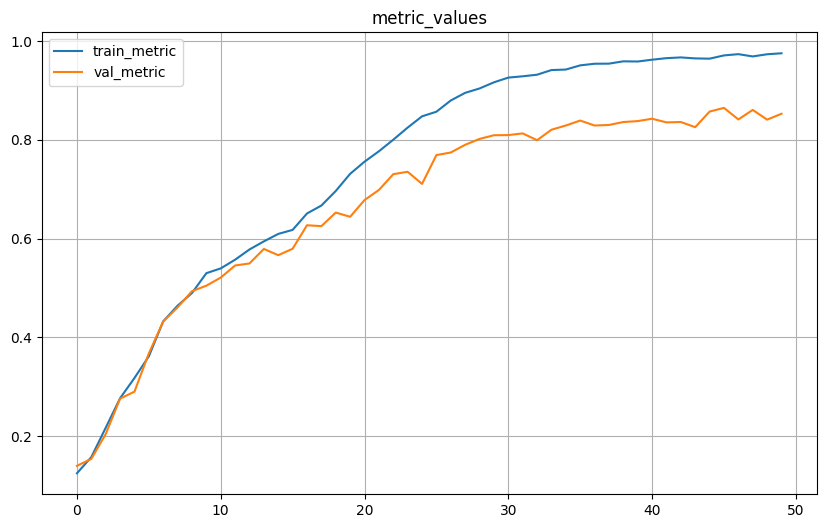

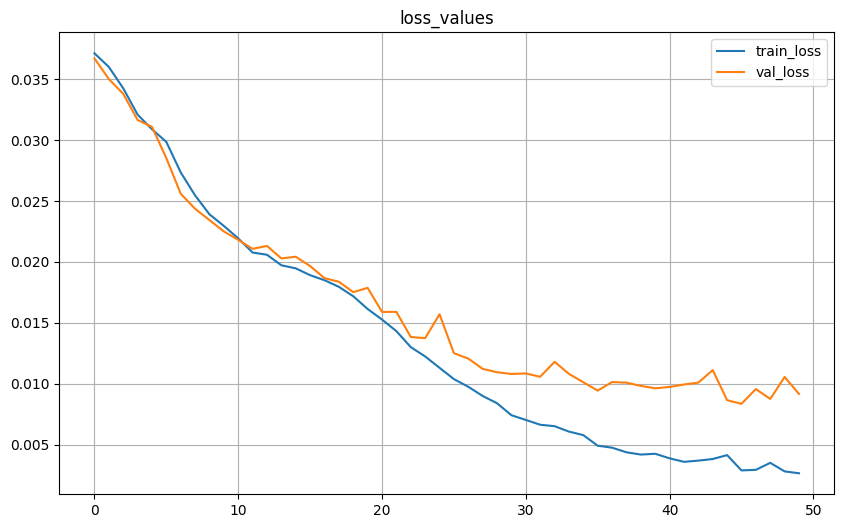

In [13]:
# ploteza graficul de modificare a acuratetei in raport cu numarul epocilor
plt.figure(figsize=(10,6)) 
plt.plot(train_metric_values, label = 'train_metric')
plt.plot(val_metric_values, label = 'val_metric')
plt.legend() 
plt.title('metric_values')
plt.grid()
plt.show()

# ploteza graficul de modificare a entropiei in raport cu numarul epocilor
plt.figure(figsize=(10,6)) 
plt.plot(train_loss_values, label = 'train_loss')
plt.plot(val_loss_values, label = 'val_loss')
plt.legend() 
plt.title('loss_values')
plt.grid()
plt.show()

In [21]:
# genereaza rezultatele de validare / testare
test_labels = []
test_pred = []

progbar_test = tf.keras.utils.Progbar(len(test_dataset)-1, unit_name = 'Test')
for step_test, (x_test, y_test) in enumerate(test_dataset):

    progbar_test.update(step_test)

    test_labels.append(y_test[0])

    y = SimpleRNN_model(x_test, training=False)
    test_pred.append(y[0])

test_labels = np.array(test_labels)
test_pred = np.array(test_pred)

test_x = np.array(test_x)
test_y = np.array(test_y)
print(test_x.shape)

1322/1322 ━━━━━━━━━━━━━━━━━━━━ 89s 67ms/Test
(1323, 10, 240, 320, 3)


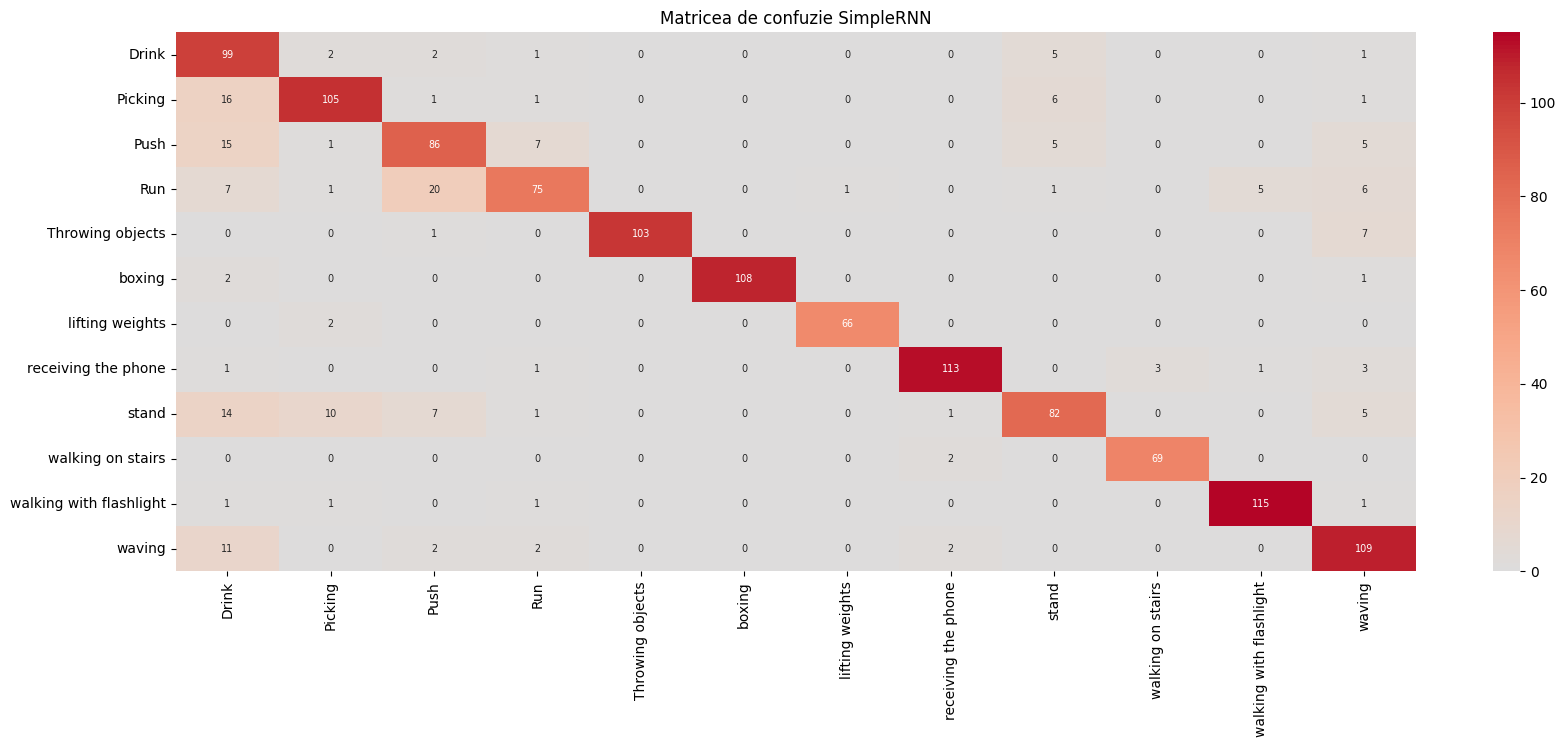

In [18]:
# creaza matricea de confuzie


# indica pozitia valorii maxime de pe fiecare rand (axis = 1 seteaza 'argmax' sa analizeze pe coloana) 
label = tf.argmax(test_labels, axis = 1)
pred = tf.argmax(test_pred, axis = 1)

# creaza matricea de confuzie
cm = tf.math.confusion_matrix(label, pred)

# creaza data frame  
cm_df = pd.DataFrame(cm, index = names_class, columns = names_class)

# ploteaza data frame
plt.figure(figsize=(20, 7))
plt.title('Matricea de confuzie SimpleRNN')
sns.heatmap(cm_df, annot=True, cmap='coolwarm', center=0, annot_kws={'size': 'x-small'}, fmt='d')
plt.savefig('rezult_SimpleRNN/SimpleRNN_matrix_conf.png')
plt.show()

In [16]:
#save model
tf.keras.models.save_model(model = SimpleRNN_model, filepath='rezult_SimpleRNN/SimpleRNN_model.keras', overwrite=True)